In [1]:
import os
import shutil
import pickle
import numpy as np
import torch
import copy
import matplotlib.pyplot as plt

# from skopt.optimizer import gp_minimize
from bcnf.gp_minimize.gp_minimize import gp_minimize_fixed
from skopt.space import Real, Categorical, Integer

from bcnf.simulation.physics import get_data
from bcnf.models.cnf import CondRealNVP
from bcnf.models.feature_network import FullyConnectedFeatureNetwork
from bcnf.eval.crossvalidate import cross_validate
from bcnf.errors import TrainingDivergedError

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
# HACK: scikit-optimize is not maintained anymore and this is a quick fix to make it work
np.int = np.int64

In [3]:
# Check if a checkpoint exists
checkpoint_file = 'checkpoint.pkl'
metrics_dir = 'metrics'
os.makedirs(metrics_dir, exist_ok=True)

In [4]:
X, y = get_data(
    T=1.0,
    dt=1 / 30,
    N=2_000,
    break_on_impact=False
)

X_tensor = torch.Tensor(X.reshape(X.shape[0], -1))
y_tensor = torch.Tensor(y)

100%|██████████| 2000/2000 [00:02<00:00, 951.38it/s]


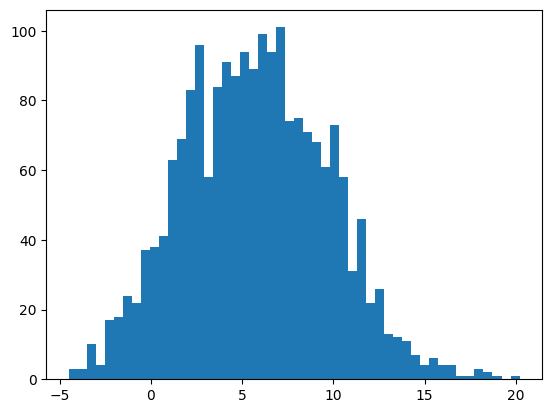

In [5]:
plt.hist(X_tensor[:, -1].numpy().flatten(), bins=50);

In [6]:
optimizer_kwargs = {
    "lr": 2e-4
}

lr_scheduler_kwargs = {
    "mode": "min",
    "factor": 0.5,
    "patience": 250,
    "threshold_mode": "abs",
    "threshold": 1e-1,
}

In [7]:
# Example search spaces
search_spaces = {
    'condition_size': Integer(1, 2048),
    'model_hidden_size': Integer(32, 256),
    'model_n_blocks': Integer(1, 32),
    'model_act_norm': Categorical([True, False]),
    'feature_network_hidden_size': Integer(16, 2048),
    'feature_network_hidden_layers': Integer(0, 16),
    'feature_network_dropout': Real(0, 0.5),
}

In [8]:
def param_index(name, search_spaces):
    return list(search_spaces.keys()).index(name)

In [9]:
model_size = y_tensor.shape[1]
feature_size = X_tensor.shape[1]

In [10]:
def score_parameters(params: list):
    print(params)
    try:
        fold_metrics = cross_validate(
            model_class=CondRealNVP,
            model_kwargs={
                "size": model_size,
                "hidden_size": params[param_index('model_hidden_size', search_spaces)],
                "n_blocks": params[param_index('model_n_blocks', search_spaces)],
                "n_conditions": params[param_index('condition_size', search_spaces)],
                "act_norm": params[param_index('model_act_norm', search_spaces)],
            },
            feature_network_class=FullyConnectedFeatureNetwork,
            feature_network_kwargs={
                "sizes": [feature_size]
                    + [params[param_index('feature_network_hidden_size', search_spaces)]] * params[param_index('feature_network_hidden_layers', search_spaces)]
                    + [params[param_index('condition_size', search_spaces)]],
                "dropout": params[param_index('feature_network_dropout', search_spaces)],    
            },
            optimizer_class=torch.optim.Adam,
            optimizer_kwargs=optimizer_kwargs,
            lr_scheduler_class=torch.optim.lr_scheduler.ReduceLROnPlateau,
            lr_scheduler_kwargs=lr_scheduler_kwargs,
            X=X_tensor,
            y=y_tensor,
            n_epochs=50_000,
            val_loss_patience=500,
            val_loss_tolerance=1e-1,
            val_loss_tolerance_mode="abs",
            timeout=60 * 60,  # 1 hour
            batch_size=256,
            device=device,
            verbose=True,
            n_splits=3,
            errors="raise"
        )

        # Save the metrics
        with open(f'{metrics_dir}/params_{"_".join([str(p) for p in params])}.pkl', 'wb') as f:
            pickle.dump(fold_metrics, f)

    except TrainingDivergedError as e:
        print(e)
        return 100  # A big number

    val_loss_list = [r['val_loss'][1] for r in fold_metrics]  # each val_loss value is a tuple (epoch, loss)
    print(f'Val Loss: {np.mean(val_loss_list):.4f} ± {np.std(val_loss_list):.4f}')
    return np.mean(val_loss_list) + np.std(val_loss_list)

In [11]:
# Define a callback function to save the results
def save_checkpoint(result):
    # Save the checkpoint after each iteration or at the end of the optimization
    with open(checkpoint_file + ".tmp", 'wb') as f:
        # Ignore
        # - result['specs']['args']['func']
        # - result['specs']['args']['callback']
        # because it causes problems when reading somewhere else
        result_no_func = copy.deepcopy(result)
        del result_no_func['specs']['args']['func']
        del result_no_func['specs']['args']['callback']
        pickle.dump(result_no_func, f)

    # Delete the old checkpoint file and rename the temporary file
    shutil.move(checkpoint_file + ".tmp", checkpoint_file)

In [12]:
N_STEPS_INIT = 10
N_STEPS = 100

In [13]:
if os.path.exists(checkpoint_file):
    print(f'Loading checkpoint from {checkpoint_file}')
    with open(checkpoint_file, 'rb') as f:
        checkpoint = pickle.load(f)
        checkpoint['specs']['args']['func'] = score_parameters
        checkpoint['specs']['args']['callback'] = save_checkpoint
    print(f'Resuming from iteration {len(checkpoint.x_iters)}')
else:
    print('No checkpoint found. Starting new optimization')
    checkpoint = None

n_initial_points = max(0, N_STEPS_INIT - len(checkpoint.x_iters)) if checkpoint else N_STEPS_INIT
n_calls_remaining = max(0, N_STEPS - len(checkpoint.x_iters)) if checkpoint else N_STEPS

print(f'Running with {n_initial_points} initial points and {n_calls_remaining} remaining iterations')

# You might want to adjust the n_calls or other parameters based on the checkpoint
result = gp_minimize_fixed(
    func=score_parameters,
    dimensions=search_spaces.values(),
    n_initial_points=n_initial_points,  # Number of random points before starting the optimization
    n_calls=n_calls_remaining,  # Number of iterations
    random_state=2024_03_25,
    verbose=True,
    callback=save_checkpoint,
    x0=checkpoint.x_iters if checkpoint else None,
    y0=checkpoint.func_vals if checkpoint else None)

Loading checkpoint from checkpoint.pkl
Resuming from iteration 95
Running with 0 initial points and 5 remaining iterations
0 initial points will be randomly generated
Iteration No: 1 started. Searching for the next optimal point.
Telling optimizer about 95 initial points
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 2.0591
Function value obtained: -20.4135
Current minimum: -53.3666
Iteration No: 2 started. Searching for the next optimal point.
[2048, 256, 32, False, 2048, 9, 0.0]


Train: -44.9218 - Val: 154.4365 (avg: 133.3613, min: -19.0563) | lr: 1.00e-04 - Patience: 500/500:   2%|▏         | 1232/50000 [04:07<2:43:14,  4.98it/s]
Train: -22.6586 - Val: -19.2061 (avg: -18.1062, min: -18.7781) | lr: 2.00e-04 - Patience: 27/500:   2%|▏         | 753/50000 [02:32<2:45:51,  4.95it/s]


Error in fold 1: Loss exploded to 263129382912.0 at epoch 753.3333333333334
Loss exploded to 263129382912.0 at epoch 753.3333333333334
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 402.0372
Function value obtained: 100.0000
Current minimum: -53.3666
Iteration No: 3 started. Searching for the next optimal point.
[1588, 161, 23, True, 31, 3, 0.3779247177629724]


Train: -55.3583 - Val: -53.6495 (avg: -53.6480, min: -53.5591) | lr: 1.95e-07 - Patience: 500/500:  26%|██▌       | 12977/50000 [30:11<1:26:07,  7.16it/s]
Train: -54.5522 - Val: -53.8717 (avg: -53.8755, min: -53.8081) | lr: 1.95e-07 - Patience: 500/500:  26%|██▌       | 12950/50000 [30:28<1:27:12,  7.08it/s]
Train: -54.8296 - Val: -53.0909 (avg: -53.0882, min: -53.0344) | lr: 1.95e-07 - Patience: 500/500:  25%|██▍       | 12412/50000 [29:13<1:28:29,  7.08it/s]


Val Loss: -53.7204 ± 0.4293
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 5395.7605
Function value obtained: -53.2911
Current minimum: -53.3666
Iteration No: 4 started. Searching for the next optimal point.
[1667, 157, 23, True, 16, 3, 0.3886034390791541]


Train: -51.9401 - Val: -47.6704 (avg: -47.6710, min: -47.6082) | lr: 1.95e-07 - Patience: 500/500:  25%|██▌       | 12559/50000 [28:17<1:24:20,  7.40it/s]
Train: -50.3264 - Val: -47.0274 (avg: -47.0168, min: -46.9642) | lr: 1.95e-07 - Patience: 500/500:  22%|██▏       | 11035/50000 [24:53<1:27:52,  7.39it/s]
Train: -51.8917 - Val: -50.5903 (avg: -50.5755, min: -50.5198) | lr: 1.95e-07 - Patience: 500/500:  25%|██▌       | 12707/50000 [33:27<1:38:13,  6.33it/s]


Val Loss: -48.6457 ± 2.1067
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 5202.7053
Function value obtained: -46.5390
Current minimum: -53.3666
Iteration No: 5 started. Searching for the next optimal point.
[1419, 185, 23, True, 16, 3, 0.2955871293071425]


Train: -47.9826 - Val: -47.3639 (avg: -47.3392, min: -47.2664) | lr: 1.95e-07 - Patience: 500/500:  23%|██▎       | 11287/50000 [26:01<1:29:14,  7.23it/s]
Train: -50.4779 - Val: -38.9500 (avg: -38.9284, min: -38.8831) | lr: 1.95e-07 - Patience: 500/500:  23%|██▎       | 11704/50000 [27:06<1:28:40,  7.20it/s]
Train: -47.5920 - Val: -47.1479 (avg: -47.1440, min: -47.0653) | lr: 1.95e-07 - Patience: 500/500:  22%|██▏       | 10925/50000 [21:34<1:17:08,  8.44it/s]


Val Loss: -45.1692 ± 3.1928
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 4482.4986
Function value obtained: -41.9764
Current minimum: -53.3666
[1493, 127, 25, True, 144, 3, 0.4071232380674507]


Train: -54.9287 - Val: -46.4215 (avg: -46.4720, min: -46.4336) | lr: 3.91e-07 - Patience: 500/500:  21%|██        | 10351/50000 [21:10<1:21:06,  8.15it/s]
Train: -55.4238 - Val: -52.9430 (avg: -52.9247, min: -52.8466) | lr: 3.91e-07 - Patience: 500/500:  23%|██▎       | 11513/50000 [23:29<1:18:31,  8.17it/s]
Train: -54.2875 - Val: -53.6901 (avg: -53.6754, min: -53.5977) | lr: 1.95e-07 - Patience: 500/500:  23%|██▎       | 11681/50000 [23:51<1:18:16,  8.16it/s]


Val Loss: -51.5423 ± 3.2553
Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 8595.2766
Function value obtained: -48.2871
Current minimum: -53.3666
